In [20]:
import os
import pickle
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as ms
from tqdm import tqdm
import librosa
import math
import random
import pandas as pd
import IPython.display
import librosa.display
ms.use('seaborn-muted')
%matplotlib inline

In [21]:
data_dir = '/home/rashmi/BE Project/pre-processed/'
labels_df_path = '{}df_iemocap1.csv'.format(data_dir)
audio_vectors_path = '{}audio_vectors_5.pkl'.format(data_dir)

In [22]:
labels_df = pd.read_csv(labels_df_path)
audio_vectors = pickle.load(open(audio_vectors_path, 'rb'))

In [23]:
random_file_name = list(audio_vectors.keys())[random.choice(range(len(audio_vectors.keys())))]
y = audio_vectors[random_file_name]
sr = 44100

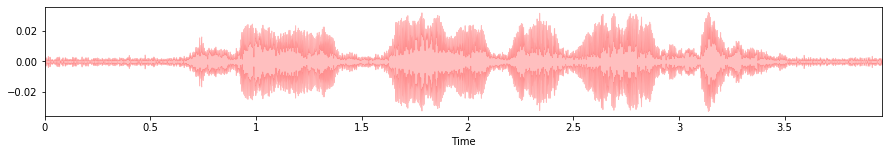

In [24]:
plt.figure(figsize=(15,2))
librosa.display.waveplot(y, sr=sr, max_sr=1000, alpha=0.25, color='r')

In [25]:
print('Signal mean = {:.5f}'.format(np.mean(abs(y))))
print('Signal std dev = {:.5f}'.format(np.std(y)))

Signal mean = 0.00407
Signal std dev = 0.00633


RMS mean = 0.00505
RMS std dev = 0.00380


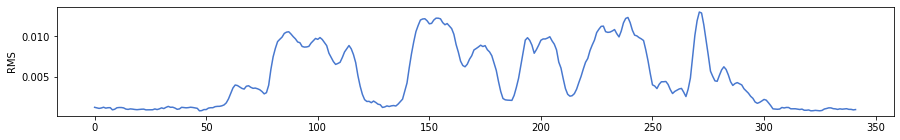

In [26]:
rms = librosa.feature.rms(y + 0.0001)[0]
plt.figure(figsize=(15,2))
plt.plot(rms)
plt.ylabel('RMS')
print('RMS mean = {:.5f}'.format(np.mean(rms)))
print('RMS std dev = {:.5f}'.format(np.std(rms)))

In [27]:
from IPython.display import Audio
Audio(y, rate=44100)

In [28]:
silence = 0
for e in rms:
    if e <= 0.4 * np.mean(rms):
        silence += 1
print(silence/float(len(rms)))

0.3508771929824561


In [29]:
y_harmonic, y_percussive = librosa.effects.hpss(y)
np.mean(y_harmonic)

-1.0675364e-05

In [30]:
autocorr = librosa.core.autocorrelate(y)
np.max(autocorr)

6.989

In [31]:
cl = 0.45 * np.mean(abs(y))
center_clipped = []
for s in y:
    if s >= cl:
        center_clipped.append(s - cl)
    elif s <= -cl:
        center_clipped.append(s + cl)
    elif np.abs(s) < cl:
        center_clipped.append(0)
new_autocorr = librosa.core.autocorrelate(np.array(center_clipped))
np.max(new_autocorr)

4.859944434895619

In [32]:
columns = ['wav_file', 'label', 'sig_mean', 'sig_std', 'rmse_mean', 'rmse_std', 'silence', 'harmonic', 'auto_corr_max', 'auto_corr_std']
df_features = pd.DataFrame(columns=columns)

In [33]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'exc': 2,
                'sad': 3,
                'fru': 4,
                'fea': 5,
                'sur': 6,
                'neu': 7,
                'xxx': 8,
                'oth': 8}

data_dir = '/home/rashmi/BE Project/pre-processed/'
labels_path = '{}df_iemocap1.csv'.format(data_dir)
audio_vectors_path = '{}audio_vectors_'.format(data_dir)

In [1]:
labels_df = pd.read_csv(labels_path)

for sess in [5]: # using one session due to memory constraint, can replace [5] with range(1, 6)
        audio_vectors = pickle.load(open('{}{}.pkl'.format(audio_vectors_path, sess), 'rb'))
        for index, row in tqdm(labels_df[labels_df['wav_file'].str.contains('Ses0{}'.format(sess))].iterrows()):
            try:
                wav_file_name = row['wav_file']
                label = emotion_dict[row['emotion']]
                y = audio_vectors[wav_file_name]

                feature_list = [wav_file_name, label]  # wav_file, label
                sig_mean = np.mean(abs(y))
                feature_list.append(sig_mean)  # sig_mean
                feature_list.append(np.std(y))  # sig_std

                rms = librosa.feature.rms(y + 0.0001)[0]
                feature_list.append(np.mean(rms))  # rms_mean
                feature_list.append(np.std(rms))  # rms_std

                silence = 0
                for e in rms:
                    if e <= 0.4 * np.mean(rms):
                        silence += 1
                silence /= float(len(rms))
                feature_list.append(silence)  # silence

                y_harmonic = librosa.effects.hpss(y)[0]
                feature_list.append(np.mean(y_harmonic) * 1000)  # harmonic (scaled by 1000)

                # based on the pitch detection algorithm mentioned here:
                # http://access.feld.cvut.cz/view.php?cisloclanku=2009060001
                cl = 0.45 * sig_mean
                center_clipped = []
                for s in y:
                    if s >= cl:
                        center_clipped.append(s - cl)
                    elif s <= -cl:
                        center_clipped.append(s + cl)
                    elif np.abs(s) < cl:
                        center_clipped.append(0)
                auto_corrs = librosa.core.autocorrelate(np.array(center_clipped))
                feature_list.append(1000 * np.max(auto_corrs)/len(auto_corrs))  # auto_corr_max (scaled by 1000)
                feature_list.append(np.std(auto_corrs))  # auto_corr_std

                df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
            except Exception as e: print(e)

df_features.to_csv('/home/rashmi/Dataset/single_file/pre-processed/audio_features.csv', index=False)

NameError: name 'pd' is not defined